In [1]:
import ast
import numpy as np
import json
import torch
import mace
import matplotlib
import matplotlib.pyplot as plt
import scipy

from tqdm import tqdm

from mace.tools import torch_geometric
from mace.data import HDF5Dataset

/home/pbenner/.local/opt/anaconda3/envs/mace/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
model = torch.load('data-train-result-stress-128/MACE_MPtrj_2022.9.model')

In [4]:
with open('data-train-preprocessed/statistics.json', "r") as f:
    statistics = json.load(f)

zs_list = ast.literal_eval(statistics["atomic_numbers"])
z_table = mace.tools.get_atomic_number_table_from_zs(zs_list)

In [5]:
train_set = HDF5Dataset(
    'data-train-preprocessed/train.h5', r_max=4.5, z_table = z_table,
)
#valid_set = HDF5Dataset(
#    'data-train-preprocessed/valid.h5', r_max=4.5, z_table = z_table,
#)

In [7]:
train_loader = torch_geometric.dataloader.DataLoader(
    dataset=train_set,
    batch_size=128,   
    shuffle=False,
    drop_last=False,
    pin_memory=False,
    num_workers=1,
)
#valid_loader = torch_geometric.dataloader.DataLoader(
#    dataset=valid_set,
#    batch_size=128,   
#    shuffle=False,
#    drop_last=False,
#    pin_memory=False,
#    num_workers=1,
#)

In [13]:
device = 'cuda:0'

model = model.to(device)

stress_true = [[], [], [], [], [], [], [], [], []]
stress_pred = [[], [], [], [], [], [], [], [], []]

n = 100

for i, batch in tqdm(enumerate(train_loader), total=n):
    if i >= n:
        break

    batch = batch.to(device)
    batch_dict = batch.to_dict()
    output = model(
        batch_dict,
        training=False,
        compute_force=False,
        compute_virials=False,
        compute_stress=True,
    )

    # s11
    stress_true[0].extend([ s[0][0].item() for s in batch ['stress'] ])
    stress_pred[0].extend([ s[0][0].item() for s in output['stress'] ])

    # s12
    stress_true[1].extend([ s[0][1].item() for s in batch ['stress'] ])
    stress_pred[1].extend([ s[0][1].item() for s in output['stress'] ])

    # s13
    stress_true[2].extend([ s[0][2].item() for s in batch ['stress'] ])
    stress_pred[2].extend([ s[0][2].item() for s in output['stress'] ])

    # s21
    stress_true[3].extend([ s[1][0].item() for s in batch ['stress'] ])
    stress_pred[3].extend([ s[1][0].item() for s in output['stress'] ])

    # s22
    stress_true[4].extend([ s[1][1].item() for s in batch ['stress'] ])
    stress_pred[4].extend([ s[1][1].item() for s in output['stress'] ])

    # s23
    stress_true[5].extend([ s[1][2].item() for s in batch ['stress'] ])
    stress_pred[5].extend([ s[1][2].item() for s in output['stress'] ])

    # s31
    stress_true[6].extend([ s[2][0].item() for s in batch ['stress'] ])
    stress_pred[6].extend([ s[2][0].item() for s in output['stress'] ])

    # s32
    stress_true[7].extend([ s[2][1].item() for s in batch ['stress'] ])
    stress_pred[7].extend([ s[2][1].item() for s in output['stress'] ])

    # s33
    stress_true[8].extend([ s[2][2].item() for s in batch ['stress'] ])
    stress_pred[8].extend([ s[2][2].item() for s in output['stress'] ])

100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


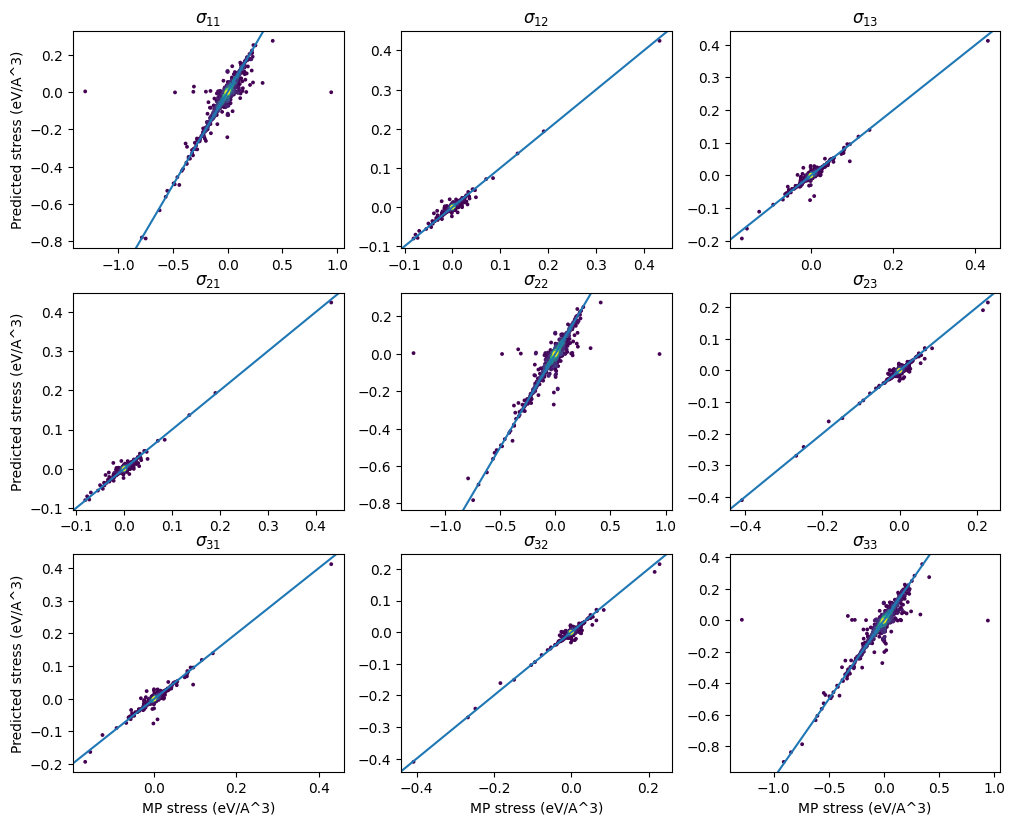

In [14]:
labels = [r'$\sigma_{11}$', r'$\sigma_{12}$', r'$\sigma_{13}$',
          r'$\sigma_{21}$', r'$\sigma_{22}$', r'$\sigma_{23}$',
          r'$\sigma_{31}$', r'$\sigma_{32}$', r'$\sigma_{33}$']

fig, axs = plt.subplots(3, 3, figsize=(10, 8))
fig.tight_layout()

for i, ax in enumerate(axs.flatten()):

    xy = np.vstack([stress_true[i], stress_pred[i]])
    z = scipy.stats.gaussian_kde(xy)(xy)

    ax.scatter(stress_true[i], stress_pred[i], c=z, s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())
    ax.axline((0,0), slope=1)
    ax.set_title(labels[i])
    if i in [6, 7, 8]:
        ax.set_xlabel('MP stress (eV/A^3)')
    if i in [0, 3, 6]:
        ax.set_ylabel('Predicted stress (eV/A^3)')

plt.show()